# DATA PREPARATION

In [43]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [44]:
base_dir = 'E:\Skripsi\Dataset'


# Melihat daftar folder di direktori saat ini
folder_list = next(os.walk(base_dir))[1]
print("Daftar folder di direktori saat ini:")
for folder in folder_list:
    print(folder)


Daftar folder di direktori saat ini:
CNN_model
coba
Data
Data lama
Training
transfer_model
transfer_modelBaru
transfer_modelBaru2
Validasi


In [45]:
bahan_dir = os.path.join(base_dir, 'Data')
train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validasi')

In [46]:
berat_dir = os.path.join(bahan_dir, 'Berat\\')
ringan_dir = os.path.join(bahan_dir, 'Ringan\\')
sedang_dir = os.path.join(bahan_dir, 'Sedang\\')
sehat_dir = os.path.join(bahan_dir, 'Sehat\\')

print("Jumlah data train tiap kelas")
print('Jumlah gambar berat :', len(os.listdir(berat_dir)))
print('Jumlah gambar ringan :', len(os.listdir(ringan_dir)))
print('Jumlah gambar sedang :', len(os.listdir(sedang_dir)))
print('Jumlah gambar sehat :', len(os.listdir(sehat_dir)))

Jumlah data train tiap kelas
Jumlah gambar berat : 299
Jumlah gambar ringan : 278
Jumlah gambar sedang : 127
Jumlah gambar sehat : 362


In [65]:
class_names = sorted(os.listdir(train_dir))
print(class_names)

['Berat', 'Ringan', 'Sedang', 'Sehat']


In [47]:
train_berat = os.path.join(train_dir, 'Berat\\')
train_ringan = os.path.join(train_dir, 'Ringan\\')
train_sedang = os.path.join(train_dir, 'Sedang\\')
train_sehat = os.path.join(train_dir, 'Sehat\\')

val_berat = os.path.join(val_dir, 'Berat\\')
val_ringan = os.path.join(val_dir, 'Ringan\\')
val_sedang = os.path.join(val_dir, 'Sedang\\')
val_sehat = os.path.join(val_dir, 'Sehat\\')

# SPLIT DATASET & IMAGE AUGMENTATION

In [ ]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    if not os.path.exists(destination):
            copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    if not os.path.exists(destination):
            copyfile(i_file, destination)

train_ratio = 0.9


source_00 = berat_dir
train_00 = train_berat
val_00 = val_berat
train_val_split(source_00, train_00, val_00, train_ratio)

source_01 = ringan_dir
train_01 = train_ringan
val_01 = val_ringan
train_val_split(source_01, train_01, val_01, train_ratio)

source_02 = sedang_dir
train_02 = train_sedang
val_02 = val_sedang
train_val_split(source_02, train_02, val_02, train_ratio)

source_03 = sehat_dir
train_03 = train_sehat
val_03 = val_sehat
train_val_split(source_03, train_03, val_03, train_ratio)

In [48]:
print('Jumlah All berat :', len(os.listdir(berat_dir)))
print('Jumlah train berat :', len(os.listdir(train_berat)))
print('Jumlah val berat : ', len(os.listdir(val_berat)))

Jumlah All berat : 299
Jumlah train berat : 269
Jumlah val berat :  30


In [49]:
train_datagen = ImageDataGenerator(
    rescale=1./255, #pembagian nilai pixel
    rotation_range = 40, #memutar gambar secara acak sampai 60 derajat
    horizontal_flip=True, #membalikan gambar secara horizontal
    vertical_flip=True, #membalikan gambar secara vertical
    shear_range=0.2, #Bagian dari gambar memperbanyak gambar untuk belajar
    fill_mode= 'nearest') #digantikan pixel terdekatnya jika hilang

validation_datagen = ImageDataGenerator(
    rescale=1./255)

In [53]:
train_generator = train_datagen.flow_from_directory(
    train_dir, #target directory
    target_size=(250,250), #mengubah ukuran pixel
    batch_size=32, #parameter untuk pelatihan disesuaikan dengan perangkat
    classes=["Berat", "Ringan", "Sedang", "Sehat"], #list kelas
    class_mode='categorical', #(Metode pemilihan data)karena data lebih dari 2
    shuffle=True) #mengacak data

validation_generator = validation_datagen.flow_from_directory(
    val_dir, #target directory
    target_size=(250,250), #mengubah ukuran pixel
    batch_size=32, #parameter untuk pelatihan disesuaikan dengan perangkat
    classes=["Berat", "Ringan", "Sedang", "Sehat"], #list kelas
    class_mode='categorical', #(Metode pemilihan data)karena data lebih dari 2
    shuffle=True) #mengacak data

Found 958 images belonging to 4 classes.
Found 108 images belonging to 4 classes.


# CONVOLUTIONAL NEURAL NETWORK

In [54]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (250,250,3)), #konvolusiaonal menggunakan kernel 3x3(dikareanakan 3x3 mewakili dari 2x2, dan 1x1) dan dengan filter yang digunakan sebanyak 32. untuk input menggunakan ukuran 150x150 pixel dengan memiliki 3 chanel warna yaitu RGB
  tf.keras.layers.MaxPooling2D(2,2), #Untuk mengurangi resolusi gambar dengan mempertahankan informasi didalamnya. dengan menggunakan jendela pooling 2x2 dan jarak antar titik(stride) adalah 2
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(32,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(128,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation= 'relu', kernel_regularizer=l2(0.001)), #pembuatan layer fully connected, dengan memilki neuron sebanyak 512 dan menggunakan aktivasi relu (Untuk proses fitur-fitur yang telah proses sebelumnya)
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 124, 124, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 124, 124, 32)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 61, 61, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 61, 61, 32)       

In [55]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000001)

In [56]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [57]:
history = model.fit(
    train_generator,  
    epochs=50,
    validation_data=validation_generator,
        shuffle = True,

    callbacks=[learning_rate_reduction])

Epoch 1/50
30/30 [==============================] - 229s 8s/step - loss: 2.0314 - accuracy: 0.3236 - val_loss: 1.8331 - val_accuracy: 0.3426 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 199s 7s/step - loss: 1.6744 - accuracy: 0.3967 - val_loss: 1.6146 - val_accuracy: 0.4630 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 189s 6s/step - loss: 1.5161 - accuracy: 0.4228 - val_loss: 1.5373 - val_accuracy: 0.3611 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: 1.4408 - accuracy: 0.4102
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
30/30 [==============================] - 194s 6s/step - loss: 1.4408 - accuracy: 0.4102 - val_loss: 1.4571 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 191s 6s/step - loss: 1.3691 - accuracy: 0.4322 - val_loss: 1.3599 - val_accuracy: 0.4722 - lr: 5.0000e-04
Epoch 6/50
30/30 [==============================] - 196s 7s/step - 

Epoch 43/50
30/30 [==============================] - 170s 6s/step - loss: 0.5229 - accuracy: 0.8163 - val_loss: 0.6741 - val_accuracy: 0.7870 - lr: 1.0000e-06
Epoch 44/50
30/30 [==============================] - 171s 6s/step - loss: 0.5106 - accuracy: 0.8424 - val_loss: 0.6734 - val_accuracy: 0.7870 - lr: 1.0000e-06
Epoch 45/50
30/30 [==============================] - 170s 6s/step - loss: 0.5281 - accuracy: 0.8246 - val_loss: 0.6729 - val_accuracy: 0.7870 - lr: 1.0000e-06
Epoch 46/50
30/30 [==============================] - 170s 6s/step - loss: 0.5155 - accuracy: 0.8267 - val_loss: 0.6708 - val_accuracy: 0.7963 - lr: 1.0000e-06
Epoch 47/50
30/30 [==============================] - 171s 6s/step - loss: 0.5183 - accuracy: 0.8225 - val_loss: 0.6710 - val_accuracy: 0.7870 - lr: 1.0000e-06
Epoch 48/50
30/30 [==============================] - 174s 6s/step - loss: 0.5096 - accuracy: 0.8319 - val_loss: 0.6724 - val_accuracy: 0.7870 - lr: 1.0000e-06
Epoch 49/50
30/30 [===========================

In [58]:
scores = model.evaluate(train_generator)
scores = model.evaluate(validation_generator)

4/4 [==============================] - 14s 3s/step - loss: 0.6712 - accuracy: 0.7870


#EVALUATION MODEL

In [59]:
def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

Found 108 images belonging to 4 classes.


C:\Users\Muhammad Irwansyah\AppData\Local\Temp\ipykernel_10992\2650641299.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size + 1)



Confusion Matrix

[[24  1  3  2]
 [ 1 17  1  9]
 [ 5  2  3  3]
 [ 0  1  0 36]]


Classification Report

              precision    recall  f1-score   support

       Berat       0.80      0.80      0.80        30
      Ringan       0.81      0.61      0.69        28
      Sedang       0.43      0.23      0.30        13
       Sehat       0.72      0.97      0.83        37

    accuracy                           0.74       108
   macro avg       0.69      0.65      0.66       108
weighted avg       0.73      0.74      0.72       108



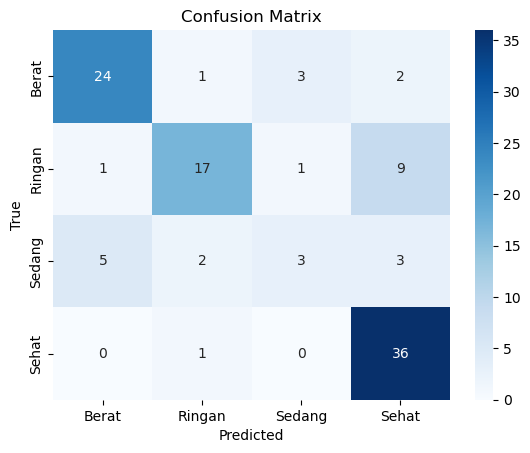

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate(model):
    validation_generator = train_datagen.flow_from_directory(
        val_dir,
        target_size=(250, 250),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    batch_size = 32
    num_of_test_samples = len(validation_generator.filenames)

    Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)

    print('\nConfusion Matrix\n')
    cm = confusion_matrix(validation_generator.classes, y_pred)
    print(cm)  # Print the confusion matrix

    print('\n\nClassification Report\n')
    target_names = ["Berat", "Ringan", "Sedang", "Sehat"]
    print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

    # Membuat heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the evaluate function with your model
evaluate(model)


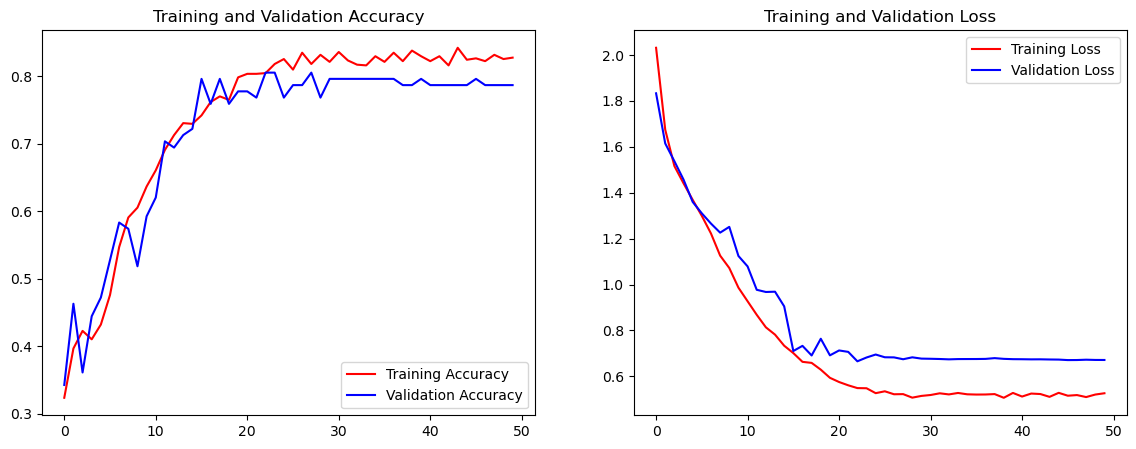

In [64]:
eval_plot(history)

1/1 [==============================] - 0s 31ms/step


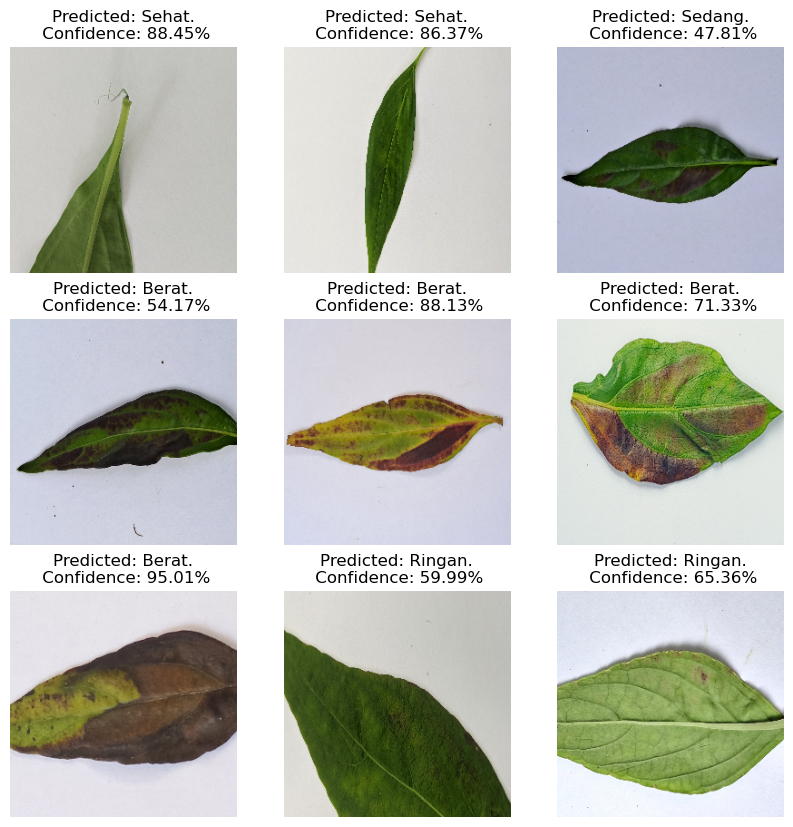

In [66]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(10, 10))
for images, labels in validation_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])

        plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
    break

# TRANSFER LEARNING

In [67]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input #Import model InceptionV3 dari TensorFlow Keras. Model ini telah dilatih sebelumnya pada dataset ImageNet.
from tensorflow.keras.models import Model #Import kelas Model dari TensorFlow Keras untuk membuat model baru.
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # Import lapisan GlobalAveragePooling2D dan Dense dari TensorFlow Keras. Lapisan ini akan digunakan untuk membangun bagian akhir dari model.
from tensorflow.keras import backend as K #Import modul backend dari TensorFlow Keras sebagai K. Modul ini digunakan untuk mengakses fungsi-fungsi backend TensorFlow.

In [68]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
base_output = base_model.output

x = GlobalAveragePooling2D()(base_output)
x = Dense(1024, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.2)(x)

predictions = Dense(len(class_names), activation='softmax')(x)
transfer_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

transfer_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [69]:
transfer_model.summary() # melihat arsitektur yang sudah dibuat

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 conv2d_25 (Conv2D)          (None, 124, 124, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 124, 124, 32)         96        ['conv2d_25[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 124, 124, 32)         0         ['batch_normalization[0][0

 conv2d_36 (Conv2D)          (None, 28, 28, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 28, 28, 64)           192       ['conv2d_30[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 28, 28, 64)           192       ['conv2d_32[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 28, 28, 96)           288       ['conv2d_35[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 28, 28, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 28, 28, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 28, 28, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_53 (Conv2D)          (None, 28, 28, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 28, 28, 96)           288       ['conv2d_53[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 28, 28, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_51 (Conv2D)          (None, 13, 13, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_55 (Conv2D)          (None, 13, 13, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_58 (Conv2D)          (None, 13, 13, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_63 (Conv2D)          (None, 13, 13, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_64 (Conv2D)          (None, 13, 13, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 13, 13, 192)          576       ['conv2d_55[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 13, 13, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_65 (Conv2D)          (None, 13, 13, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_68 (Conv2D)          (None, 13, 13, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_73 (Conv2D)          (None, 13, 13, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 13, 13, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 13, 13, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 13, 13, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_75

 batch_normalization_62 (Ba  (None, 13, 13, 192)          576       ['conv2d_87[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 13, 13, 192)          576       ['conv2d_92[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 13, 13, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 13, 13, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_96 (Conv2D)          (None, 6, 6, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_100 (Conv2D)         (None, 6, 6, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 6, 6, 320)            960       ['conv2d_96[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 6, 6, 192)            576       ['conv2d_100[0][0]']          
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 6, 6, 192)            576       ['conv2d_109[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 6, 6, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [70]:
hist = transfer_model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=10    
)

Epoch 1/10
30/30 [==============================] - 199s 7s/step - loss: 3.2157 - accuracy: 0.5699 - val_loss: 2.3304 - val_accuracy: 0.7870
Epoch 2/10
30/30 [==============================] - 184s 6s/step - loss: 2.2121 - accuracy: 0.7589 - val_loss: 1.8663 - val_accuracy: 0.8519
Epoch 3/10
30/30 [==============================] - 183s 6s/step - loss: 1.7853 - accuracy: 0.8424 - val_loss: 1.7335 - val_accuracy: 0.7963
Epoch 4/10
30/30 [==============================] - 184s 6s/step - loss: 1.6026 - accuracy: 0.8497 - val_loss: 1.5251 - val_accuracy: 0.8519
Epoch 5/10
30/30 [==============================] - 183s 6s/step - loss: 1.5366 - accuracy: 0.8142 - val_loss: 1.3634 - val_accuracy: 0.8426
Epoch 6/10
30/30 [==============================] - 186s 6s/step - loss: 1.3484 - accuracy: 0.8580 - val_loss: 1.3671 - val_accuracy: 0.8148
Epoch 7/10
30/30 [==============================] - 207s 7s/step - loss: 1.2037 - accuracy: 0.8852 - val_loss: 1.2876 - val_accuracy: 0.8056
Epoch 8/10
30

In [74]:
scores = transfer_model.evaluate(train_generator)
scores = transfer_model.evaluate(validation_generator)

4/4 [==============================] - 20s 5s/step - loss: 0.9763 - accuracy: 0.8796


#EVALUATON MODEL

In [71]:
def eval_plot(hist):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

Found 108 images belonging to 4 classes.


C:\Users\Muhammad Irwansyah\AppData\Local\Temp\ipykernel_10992\4230632298.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = transfer_model.predict_generator(validation_generator, num_of_test_samples // batch_size + 1)



Confusion Matrix

[[28  0  1  1]
 [ 1 24  2  1]
 [ 0  2 11  0]
 [ 1  2  1 33]]


Classification Report

              precision    recall  f1-score   support

       Berat       0.93      0.93      0.93        30
      Ringan       0.86      0.86      0.86        28
      Sedang       0.73      0.85      0.79        13
       Sehat       0.94      0.89      0.92        37

    accuracy                           0.89       108
   macro avg       0.87      0.88      0.87       108
weighted avg       0.89      0.89      0.89       108



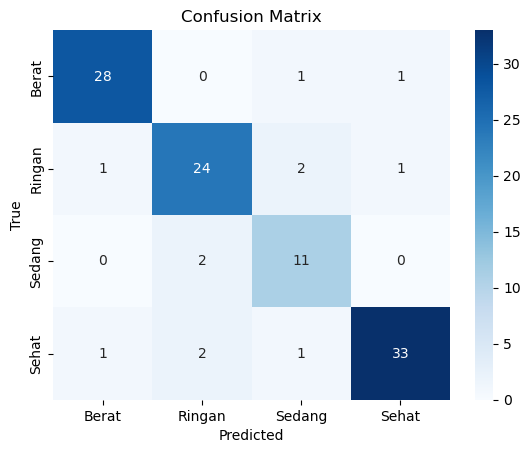

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate(transfer_model):
    validation_generator = train_datagen.flow_from_directory(
        val_dir,
        target_size=(250, 250),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    batch_size = 32
    num_of_test_samples = len(validation_generator.filenames)

    Y_pred = transfer_model.predict_generator(validation_generator, num_of_test_samples // batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)

    print('\nConfusion Matrix\n')
    cm = confusion_matrix(validation_generator.classes, y_pred)
    print(cm)  # Print the confusion matrix

    print('\n\nClassification Report\n')
    target_names = ["Berat", "Ringan", "Sedang", "Sehat"]
    print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

    # Membuat heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the evaluate function with your model
evaluate(transfer_model)


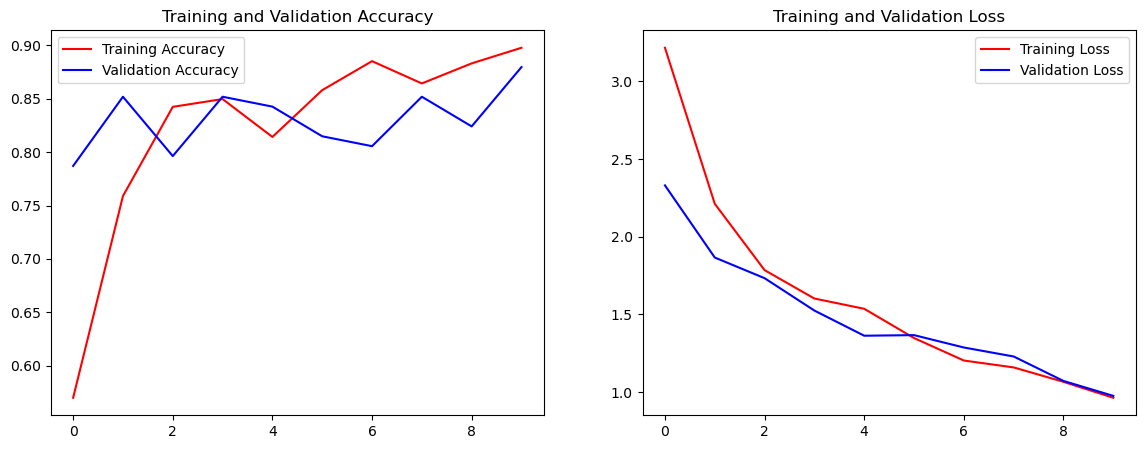

In [73]:
eval_plot(hist)

1/1 [==============================] - 0s 80ms/step


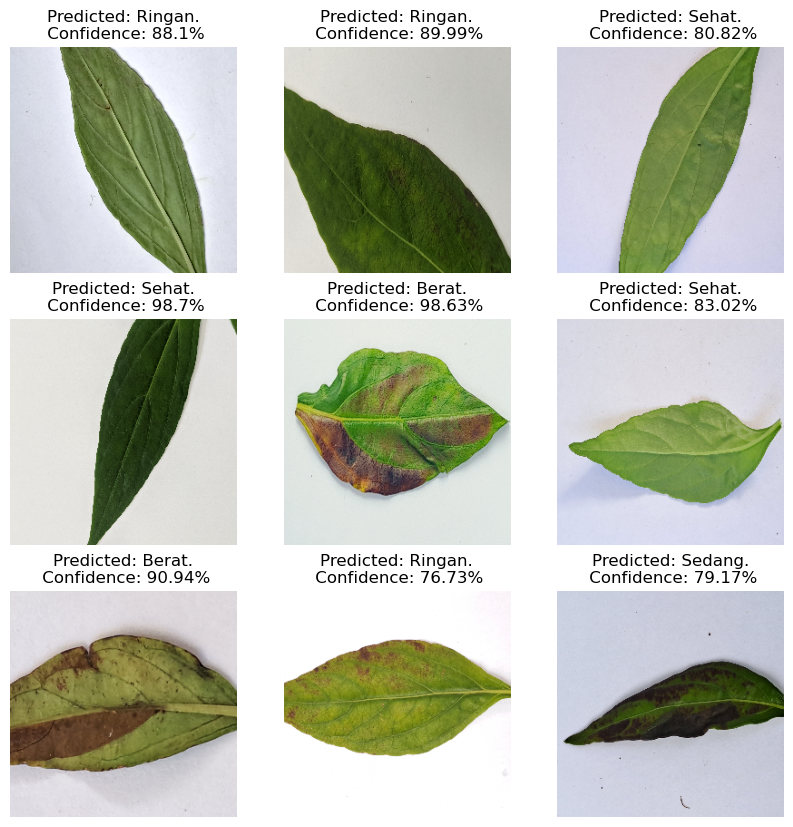

In [75]:
def predict(transfer_model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = transfer_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(10, 10))
for images, labels in validation_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(transfer_model, images[i])

        plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
    break

# SAVED MODEL & CONVERT MODEL

#CNN

In [78]:
model.save('E:/Skripsi/Dataset/fix/CNN_model.h5')
model.save('E:/Skripsi/Dataset/fix/CNN_model')

!zip -r 'CNN_model.zip' 'CNN_model'

INFO:tensorflow:Assets written to: E:/Skripsi/Dataset/fix/CNN_model\assets


INFO:tensorflow:Assets written to: E:/Skripsi/Dataset/fix/CNN_model\assets
'zip' is not recognized as an internal or external command,
operable program or batch file.


In [79]:
import pathlib

# Load the SavedModel
saved_model_dir = 'E:/Skripsi/Dataset/fix/CNN_model'
model = tf.saved_model.load(saved_model_dir)

# Convert the SavedModel to TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_file = pathlib.Path(r'E:/Skripsi/Dataset/fix/CNN_model/CNN_model.tflite')
tflite_model_file.write_bytes(tflite_model)

1794808

#TRANSFER LEARNING

In [81]:
transfer_model.save('E:/Skripsi/Dataset/fix/transfer_model.h5')
transfer_model.save('E:/Skripsi/Dataset/fix/transfer_model')

!zip -r 'transfer_model.zip' 'transfer_model'

C:\Users\Public\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: E:/Skripsi/Dataset/fix/transfer_model\assets


INFO:tensorflow:Assets written to: E:/Skripsi/Dataset/fix/transfer_model\assets
'zip' is not recognized as an internal or external command,
operable program or batch file.


In [82]:
import pathlib

# Load the SavedModel
saved_transfer_model_dir = 'E:/Skripsi/Dataset/fix/transfer_model'
transfer_model = tf.saved_model.load(saved_transfer_model_dir)

# Convert the SavedModel to TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_transfer_model_dir)

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Convert the model
tflite_transfer_model = converter.convert()

# Save the TFLite model
tflite_model_file = pathlib.Path(r'E:/Skripsi/Dataset/fix/transfer_model/transfer_model.tflite')
tflite_model_file.write_bytes(tflite_transfer_model)

24187760